# 1. Installing necessary libraries

In [1]:
%%capture
!pip install datasets
!pip install transformers
!pip install evaluate

# 2. Importing libraries

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import notebook_login
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from sklearn.metrics import accuracy_score , f1_score

In [3]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


# 3. Loading Data

In [4]:
dataset = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

# 4. EDA

Although Datasets provides a lot of low-level functionality to slice and dice our
data, it is often convenient to convert a Dataset object to a Pandas DataFrame so we
can access high-level APIs for data visualization.

In [7]:
dataset.set_format(type = 'pandas')
df = dataset['train'][:]

In [8]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


here you can apply what you want using keras functions but we do just some data visualization, you maybe wondering what is that numbers are representing

In [9]:
def label_int2str(row):
  return dataset['train'].features['label'].int2str(row)

In [57]:
id2label  = {}
label2id  = {}

for index in range(6):
  id2label[index] = dataset['train'].features['label'].int2str(index)
  label2id[dataset['train'].features['label'].int2str(index)] = index

In [58]:
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [59]:
label2id

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [60]:
df['label_name'] = df['label'].apply(label_int2str)

In [61]:
df.head()

,text,label,label_name,tweet_long
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


checking the distribution of classes


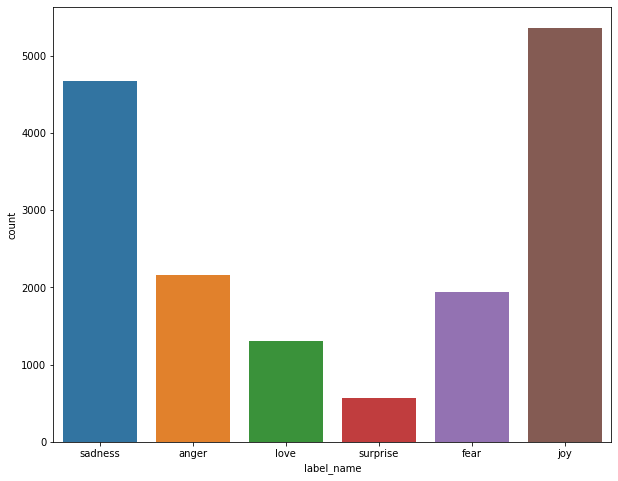

In [62]:
plt.figure(figsize = (10,8))
sns.countplot(x = df['label_name'] )
plt.show()

how long are out tweets ?

In [63]:
df['tweet_long'] = df['text'].str.split().map(lambda x : len(x))

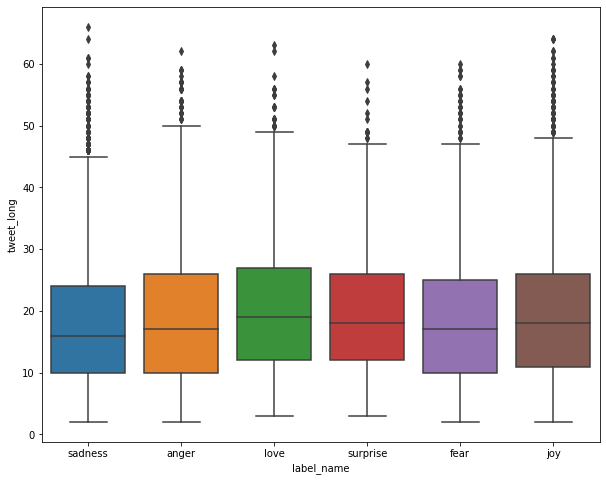

In [64]:
plt.figure(figsize = (10,8))
sns.boxplot(y = df['tweet_long'] , x =df['label_name'])
plt.show()

In [65]:
dataset.reset_format() #to be able to do our low level processing

# 5. preprocess

here we are using subword tokenizer, that really have some advantages
- split the rare words into smaller units to allow model to deal with complex words
- keep the frequent words as uniaue entites, so that we can keep the length of our inputs to a manageable size

In [66]:
_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(_ckpt)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

some exploring of the tokenizer

In [67]:
encoded_text = tokenizer('Tokenizing text is acore task of NLP')
print(f'that is the encoded text {encoded_text}')

token = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(f'that is the token text {token}')

string = tokenizer.convert_tokens_to_string(token)
print(f'that is the token text converted back to string {string}')


that is the encoded text {'input_ids': [101, 19204, 6026, 3793, 2003, 9353, 5686, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
that is the token text ['[CLS]', 'token', '##izing', 'text', 'is', 'ac', '##ore', 'task', 'of', 'nl', '##p', '[SEP]']
that is the token text converted back to string [CLS] tokenizing text is acore task of nlp [SEP]


In [68]:
(f'the tokenizer vocab size is : {tokenizer.vocab_size}')

'the tokenizer vocab size is : 30522'

In [69]:
(f'the tokenizer max length is : {tokenizer.model_max_length}')

'the tokenizer max length is : 512'

In [70]:
(f'the output of this tokenizer is : {tokenizer.model_input_names}')

"the output of this tokenizer is : ['input_ids', 'attention_mask']"

In [71]:
def preprocess_function(example):
  #turncate seq to be no longer than DistilBERT’s maximum input length
  #padding will pad the example with zeros to the maximun of the longest one in a batch
  return tokenizer(example['text'] , truncation = True , padding = True)

In [72]:
emotions_encoded  = dataset.map(preprocess_function , batched = True , batch_size = None) #speed up by processing multiple elements

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [73]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [74]:
emotions_encoded 

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# 6. train

In [75]:
from transformers import AutoModelForSequenceClassification 

num_labels = 6
device = torch.device('cuda'  if torch.cuda.is_available() else 'cpu')
#so that the model run on GPU if we have one
model = AutoModelForSequenceClassification.from_pretrained(_ckpt , num_labels = num_labels 
                                                           , id2label=id2label, label2id=label2id).to(device) 

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file p

In [76]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [77]:
model_name = f'{_ckpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir = model_name ,
    learning_rate = 2e-5 ,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [78]:
trainer = Trainer(
    model = model ,
    args = training_args,
    train_dataset = emotions_encoded['train'] ,
    eval_dataset = emotions_encoded['validation'] ,
    tokenizer = tokenizer ,
    compute_metrics = compute_metrics

)

/content/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/mahmoudNG/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.


In [79]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
  Number of trainable parameters = 66958086
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.249700,0.213264,0.925500,0.925191
2,0.149800,0.165154,0.934000,0.933900
3,0.096500,0.159147,0.939000,0.939086


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-emotion/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-emotion/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-em

TrainOutput(global_step=3000, training_loss=0.24626385879516602, metrics={'train_runtime': 498.0864, 'train_samples_per_second': 96.369, 'train_steps_per_second': 6.023, 'total_flos': 1080514292544000.0, 'train_loss': 0.24626385879516602, 'epoch': 3.0})

# 7. Error analysis

In [80]:
preds_output = trainer.predict(emotions_encoded['test'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


In [81]:
preds_output.metrics

{'test_loss': 0.1876223087310791,
 'test_accuracy': 0.923,
 'test_f1': 0.9232305537138557,
 'test_runtime': 4.4183,
 'test_samples_per_second': 452.667,
 'test_steps_per_second': 28.292}

In [98]:
y_preds = np.argmax(preds_output.predictions , axis = 1)

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix

def plot_confusion_matrix(y_preds , y_true):
  cm = confusion_matrix(y_true , y_preds , normalize = 'true')
  fig, ax = plt.subplots(figsize=(10, 8))  
  disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = list(label2id.keys()))
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()


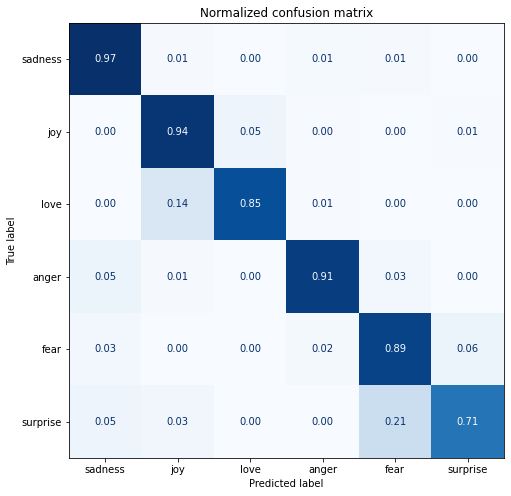

In [103]:
plot_confusion_matrix(y_preds, emotions_encoded['test']['label'])

as you can see that the love is ofter confused with joy

In [104]:
trainer.push_to_hub(commit_message="Training completed!")

Saving model checkpoint to distilbert-base-uncased-finetuned-emotion
Configuration saved in distilbert-base-uncased-finetuned-emotion/config.json
Model weights saved in distilbert-base-uncased-finetuned-emotion/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-emotion/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-emotion/special_tokens_map.json
